# Model comparison of the estimation of factor sensitivities

## Data generation

We create a 3 factor model for a return time series. The factor sensitivities are time-dependent and we compare different models to estimate them.

Inspired by Bentz: Quantitative Equity Investment Management with Time-Varying Factor Sensitivities in Dunis, Laws, Naim: Applied quantitative methods for trading and investment.

In [1]:
%matplotlib inline
import importlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from pyfinance.ols import OLS, RollingOLS, PandasRollingOLS
import pykalman
from pykalman import KalmanFilter
from scipy.interpolate import splrep, splev
import multiprocessing as mp
from functools import partial

import functions_kalman as fk

In [2]:
# Sensitivity type
# Random smooth creates random smooth sensitivities using spleens
# Random walk creates random walk sensitivities 
# Various smooth creates sensitivities having interesting shapes: a steady trend, a sudden jump and an oscillation.
sens_type = "Various smooth" #"Random smooth" # "Random walk" # 
# The number of time steps in our experiments
timespan = 10000
# Any prediction in the burn period is ignored when evaluating the performance. This is useful for the exponentially 
# weighted regression or the Kalman filter, which need some time to produce reasonable predictions. The burn period 
# is measured in time steps.
burn_period = 500
# The amplitude of the noise term in the factor model. The higher it is, the fainter the signal associated to the
# associated to the factors.
return_noise = 1.0

In [3]:
# Hyperparameters for the various models.
if sens_type == "Random walk":
    # Rolling window for ols regression
    rolling_ols_window = 400
    # Lambda parameter for exponentially weighted ols regression
    exp_rolling_ols_lambda = 0.005
    # Transition covariance/observatiaion covariance for the Kalman filter 
    kalman_covariance_ratio = 0.00002
    # "Momentum" for the naive trend Kalman filter
    nt_factor = 0.5
    # Rolling window over which to compute the momentum
    nt_window = 100
    # Transition covariance/observation covariance for the stochastic trend Kalman filter.
    stkf_covariance_ratio = 2e-10
elif sens_type == "Various smooth":
    rolling_ols_window = 200
    exp_rolling_ols_lambda = 0.01
    kalman_covariance_ratio = 0.0001
    stkf_covariance_ratio = 1e-9
    nt_factor = 0.5
    nt_window = 100
elif sens_type == "Random smooth":
    if return_noise == 1.0:
        # Optimal parameters for weighted accuracy
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 2e-4
        stkf_covariance_ratio = 5e-9
        nt_factor = 0.5
        nt_window = 100
        """
        # Optimal parameters for MSE optimized
        rolling_ols_window = 100
        exp_rolling_ols_lambda=0.02 #0.005
        kalman_covariance_ratio = 5e-4
        stkf_covariance_ratio = 1e-8
        nt_factor = 0.5
        nt_window = 100
        """
    elif return_noise == 10.0:
        # Optimal parameters for weighted accuracy
        rolling_ols_window = 500
        exp_rolling_ols_lambda = 0.002 #0.005
        kalman_covariance_ratio = 1e-5
        stkf_covariance_ratio = 5e-12
        nt_factor = 0.5
        nt_window = 500

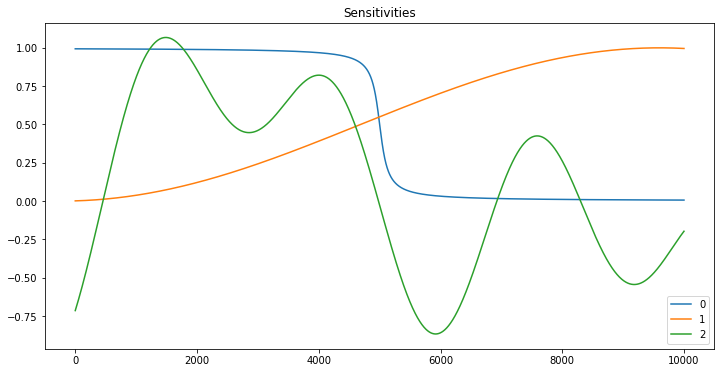

In [4]:
# Sensitivities
sens = fk.get_sensitivities(timespan, sens_type)
sens.plot(figsize=(12,6), title="Sensitivities")

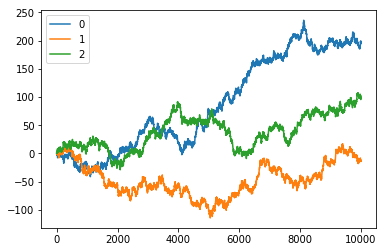

In [5]:
# Factors
factors = fk.get_factors(timespan)
factors.cumsum(axis=0).plot()

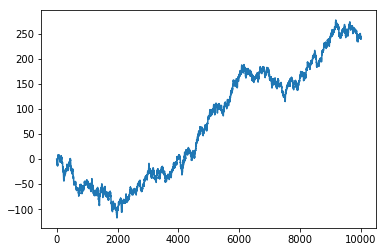

In [6]:
# Returns
returns = fk.get_returns(timespan, factors, sens, return_noise)
returns.cumsum().plot()

In [7]:
# Dictionaries to record the mse and the weighted accuracy
performance_record_mse = {}
performance_record_wacc = {}
# To have consistent colors in the plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Constant regression

MSE for Constant OLS, assuming the factors known: 1.6726908040504196
Weighted accuracy for Constant OLS, assuming the factors known: 0.6143528471798849


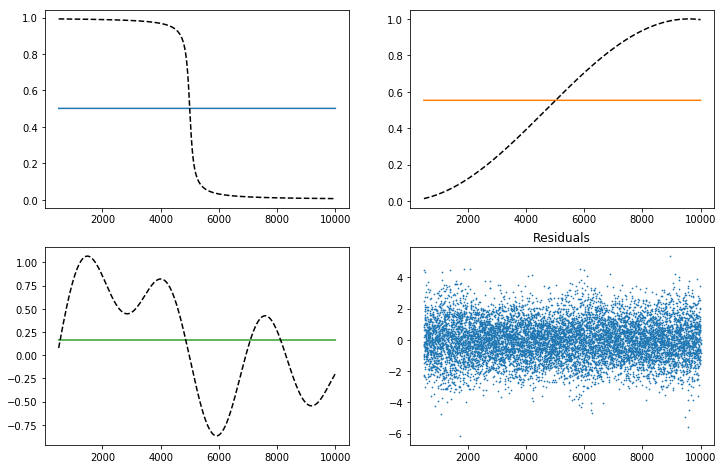

In [8]:
# Estimates the sensitivities
estimated_sensitivities_cr = fk.estimate_sensitivities_cr(factors, returns)
# Plots the estimated sensitivities
fk.plot_estimated_sensitivities(sens.loc[burn_period:,:], estimated_sensitivities_cr.loc[burn_period:,:], colors)
# Performance report and plots the residuals
fk.plot_prediction_performance(factors.loc[burn_period:,:], 
                               returns.loc[burn_period:], 
                               estimated_sensitivities_cr.loc[burn_period:,:], 
                               "Constant OLS", 
                               performance_record_mse, 
                               performance_record_wacc)

## Rolling regression

MSE for Rolling OLS, assuming the factors known: 1.0286788568745098
Weighted accuracy for Rolling OLS, assuming the factors known: 0.8739858282858506


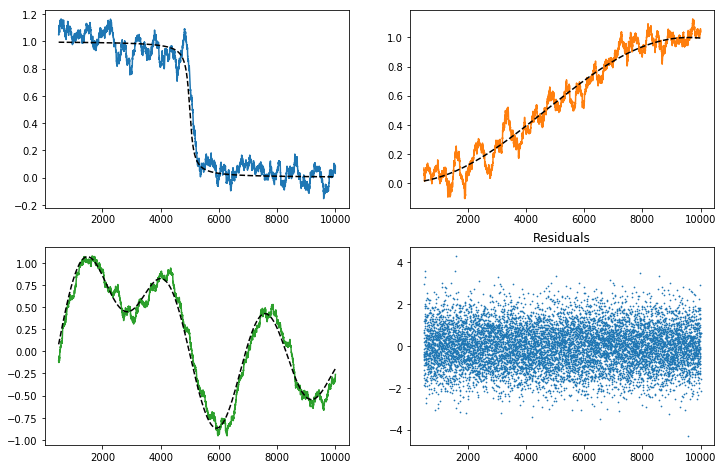

In [9]:
# Sets the window parameter to the optimized one
window = rolling_ols_window
# Estimates the sensitivities
estimated_sensitivities_rr = fk.estimate_sensitivities_rr(factors, returns, window)
# Plots the estimated sensitivities
fk.plot_estimated_sensitivities(sens.loc[burn_period:,:], estimated_sensitivities_rr.loc[burn_period:,:], colors)
# Performance report and plots the residuals
fk.plot_prediction_performance(factors.loc[burn_period:,:], 
                               returns.loc[burn_period:], 
                               estimated_sensitivities_rr.loc[burn_period:,:], 
                               "Rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Exponential rolling regression

MSE for Exponential rolling OLS, assuming the factors known: 1.0284132318549386
Weighted accuracy for Exponential rolling OLS, assuming the factors known: 0.8740338601557227


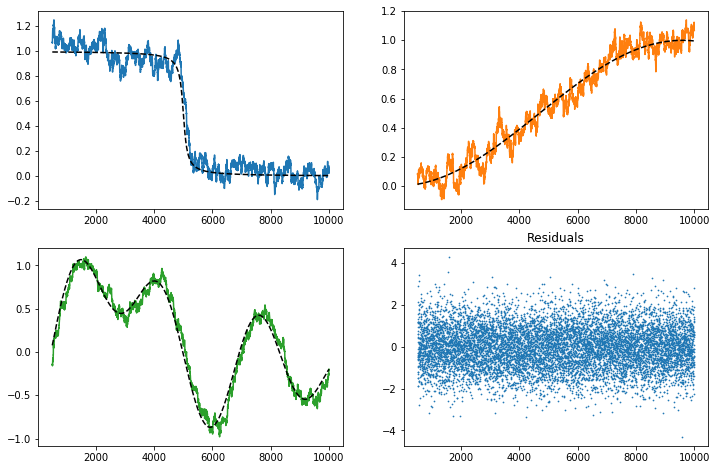

In [10]:
# Sets the lambda parameter to the optimized one
lambd = exp_rolling_ols_lambda
# Estimates the sensitivities
estimated_sensitivities_err = fk.estimate_sensitivities_err(factors, returns, lambd)
# Plots the estimated sensitivities
fk.plot_estimated_sensitivities(sens.loc[burn_period:,:], estimated_sensitivities_err.loc[burn_period:,:], colors)
# Performance report and plots the residuals
fk.plot_prediction_performance(factors.loc[burn_period:,:], 
                               returns.loc[burn_period:], 
                               estimated_sensitivities_err.loc[burn_period:,:], 
                               "Exponential rolling OLS",
                               performance_record_mse,
                               performance_record_wacc)

## Kalman filter

MSE for Kalman, assuming the factors known: 1.028204748535866
Weighted accuracy for Kalman, assuming the factors known: 0.8747328115898358


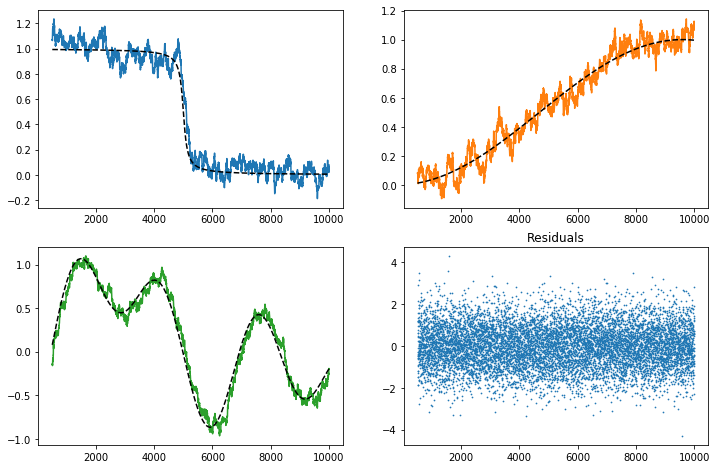

In [11]:
# Sets the covariance ratio parameter to the optimized one
covariance_ratio = kalman_covariance_ratio
# Estimates the sensitivities
estimated_sensitivities_kf = fk.estimate_sensitivities_kf(factors, returns, covariance_ratio)
# Plots the estimated sensitivities
fk.plot_estimated_sensitivities(sens.loc[burn_period:,:], estimated_sensitivities_kf.loc[burn_period:,:], colors)
# Performance report and plots the residuals
fk.plot_prediction_performance(factors.loc[burn_period:,:], 
                               returns.loc[burn_period:], 
                               estimated_sensitivities_kf.loc[burn_period:,:], 
                               "Kalman",
                               performance_record_mse,
                               performance_record_wacc)

## Local trend Kalman filter

MSE for Kalman local trend, assuming the factors known: 1.0264772360703622
Weighted accuracy for Kalman local trend, assuming the factors known: 0.8785130763720492


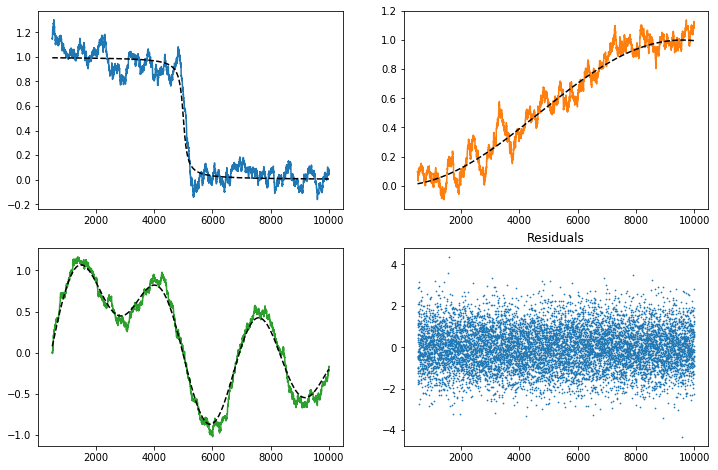

In [12]:
# Sets the covariance ratio parameter to the optimized one
covariance_ratio = stkf_covariance_ratio
# Estimates the sensitivities
estimated_sensitivities_stkf = fk.estimate_sensitivities_stkf(factors, returns, covariance_ratio)
# Plots the estimated sensitivities
fk.plot_estimated_sensitivities(sens.loc[burn_period:,:], estimated_sensitivities_stkf.loc[burn_period:,:], colors)
# Performance report and plots the residuals
fk.plot_prediction_performance(factors.loc[burn_period:,:], 
                               returns.loc[burn_period:], 
                               estimated_sensitivities_stkf.loc[burn_period:,:], 
                               "Kalman local trend",
                               performance_record_mse,
                               performance_record_wacc)

## Performance summary

In [13]:
print("MSE performance")
pd.Series(performance_record_mse).sort_values()

MSE performance


Kalman local trend         1.026477
Kalman                     1.028205
Exponential rolling OLS    1.028413
Rolling OLS                1.028679
Constant OLS               1.672691
dtype: float64

In [14]:
print("Weighted accuracy performance")
pd.Series(performance_record_wacc).sort_values(ascending=False)

Weighted accuracy performance


Kalman local trend         0.878513
Kalman                     0.874733
Exponential rolling OLS    0.874034
Rolling OLS                0.873986
Constant OLS               0.614353
dtype: float64